In [65]:
# =================
# Imports and dependencies
# =================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, t, f
from scipy.stats import (shapiro, anderson)
from matplotlib.ticker import (MultipleLocator, StrMethodFormatter)
import seaborn as sns
from datetime import datetime
import pytz
pd.set_option('display.max_columns', None)

In [66]:
# =================
# SWEEP Operator and Linear Regression Functions
# =================

def SWEEPOperator (pDim, inputM, origDiag, sweepCol = None, tol = 1e-7):
    ''' Implement the SWEEP operator

    Parameter
    ---------
    pDim: dimension of matrix inputM, integer greater than one
    inputM: a square and symmetric matrix, np array
    origDiag: the original diagonal elements before any SWEEPing
    sweepCol: a list of columns numbers to SWEEP
    tol: singularity tolerance, positive real

    Return
    ------
    A: negative of a generalized inverse of input matrix
    aliasParam: a list of aliased rows/columns in input matrix
    nonAliasParam: a list of non-aliased rows/columns in input matrix
    '''

    if (sweepCol is None):
        sweepCol = range(pDim)

    aliasParam = []
    nonAliasParam = []

    A = np.copy(inputM)
    ANext = np.zeros((pDim,pDim))

    for k in sweepCol:
        Akk = A[k,k]
        pivot = tol * abs(origDiag[k])
        if (not np.isinf(Akk) and abs(Akk) >= pivot and pivot > 0.0):
            nonAliasParam.append(k)
            ANext = A - np.outer(A[:, k], A[k, :]) / Akk
            ANext[:, k] = A[:, k] / abs(Akk)
            ANext[k, :] = ANext[:, k]
            ANext[k, k] = -1.0 / Akk
        else:
            aliasParam.append(k)
        A = ANext
    return (A, aliasParam, nonAliasParam)

def LinearRegression (X, y, tolSweep = 1e-7):
    ''' Train a linear regression model

    Argument
    --------
    X: A pd DataFrame, rows are observations, columns are regressors
    y: A pd Series, rows are observations of the response variable
    tolSweep: Tolerance for SWEEP Operator

    Return
    ------
    A list of model output:
    (0) parameter_table: a pd DataFrame of regression coefficients and statistics
    (1) cov_matrix: a pd DataFrame of covariance matrix for regression coefficient
    (2) residual_variance: residual variance
    (3) residual_df: residual degree of freedom
    (4) aliasParam: a list of aliased rows/columns in input matrix
    (5) nonAliasParam: a list of non-aliased rows/columns in input matrix
    '''

    # X: A pd DataFrame, rows are observations, columns are regressors
    # y: A pd Series, rows are observations of the response variable

    Z = X.join(y) # Combine predictors with target

    # Number of observations and regressors
    n_sample = X.shape[0]
    n_param = X.shape[1]

    # Compute X'X (ZtZ)
    ZtZ = Z.transpose().dot(Z) # Matrix multiplication X'X
    diag_ZtZ = np.diagonal(ZtZ) 
    eps_double = np.finfo(np.float64).eps
    tol = np.sqrt(eps_double)

    # Compute the transformed matrix using the SWEEP operator
    ZtZ_transf, aliasParam, nonAliasParam = SWEEPOperator ((n_param+1), ZtZ, diag_ZtZ, sweepCol = range(n_param), tol = tol)
    
    residual_df = n_sample - len(nonAliasParam) # Compute residual degrees of freedom
    residual_variance = ZtZ_transf[n_param, n_param] / residual_df # Compute residual variance

    # Extract estimated coefficients
    b = ZtZ_transf[0:n_param, n_param]
    b[aliasParam] = 0.0 # Set aliased parameters to 0

    parameter_name = X.columns

    # Construct covariance matrix
    XtX_Ginv = - residual_variance * ZtZ_transf[0:n_param, 0:n_param]
    XtX_Ginv[:, aliasParam] = 0.0
    XtX_Ginv[aliasParam, :] = 0.0
    cov_matrix = pd.DataFrame(XtX_Ginv, index = parameter_name, columns = parameter_name)

    # Build parameter summary table
    parameter_table = pd.DataFrame(index = parameter_name,
                                       columns = ['Estimate','Standard Error', 't', 'Significance', 'Lower 95 CI', 'Upper 95 CI'])
    parameter_table['Estimate'] = b
    parameter_table['Standard Error'] = np.sqrt(np.diag(cov_matrix))
    parameter_table['t'] = np.divide(parameter_table['Estimate'], parameter_table['Standard Error'])
    parameter_table['Significance'] = 2.0 * t.sf(abs(parameter_table['t']), residual_df)

    # Cconfidence intervals
    t_critical = t.ppf(0.975, residual_df)
    parameter_table['Lower 95 CI'] =  parameter_table['Estimate'] - t_critical * parameter_table['Standard Error']
    parameter_table['Upper 95 CI'] =  parameter_table['Estimate'] + t_critical * parameter_table['Standard Error']

    return ([parameter_table, cov_matrix, residual_variance, residual_df, aliasParam, nonAliasParam])

In [67]:
# =================
# Making predictions
# =================

# URL of the dataset containing historical unemployment rate and predictor variables
url = "https://raw.githubusercontent.com/sohammandal/nobel-laureates/refs/heads/main/Nobel%20Laureates%20Dataset.csv"

# Reading the CSV file from the URL
try:
    df = pd.read_csv(url)
except Exception as e:
    print("Error reading the CSV file:", e)

pd.concat([df.head(), df.tail()])

,DATE,UMCSENT,GDPC1,FEDFUNDS,SP500,PCE,CSUSHPINSA,ICSA,JTSJOR,UNRATE,CPIAUCSL
0,1984-01-01,100.1,2678.282,9.56,166.3929,2419.4,NaN,1404000.0,NaN,8.0,102.100
1,1984-02-01,97.4,2678.282,9.59,157.2505,2403.5,NaN,1357000.0,NaN,7.8,102.600
2,1984-03-01,101.0,2678.282,9.91,157.4386,2431.6,NaN,1729000.0,NaN,7.8,102.900
3,1984-04-01,96.1,2724.557,10.29,157.6015,2457.5,NaN,1477000.0,NaN,7.7,103.300
4,1984-05-01,98.1,2724.557,10.32,156.5509,2474.5,NaN,1441000.0,NaN,7.4,103.500
486,2024-07-01,66.4,7795.416,5.33,5538.0050,19862.9,325.461,953000.0,4.6,4.3,313.534
487,2024-08-01,67.9,7795.416,5.33,5478.2150,19918.4,325.025,1155000.0,4.7,4.2,314.121
488,2024-09-01,70.1,7795.416,5.13,5621.2610,20024.3,324.796,897000.0,4.5,4.1,314.686
489,2024-10-01,70.5,NaN,4.83,5792.3200,20099.5,NaN,948000.0,4.6,4.1,315.454
490,2024-11-01,NaN,NaN,4.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN


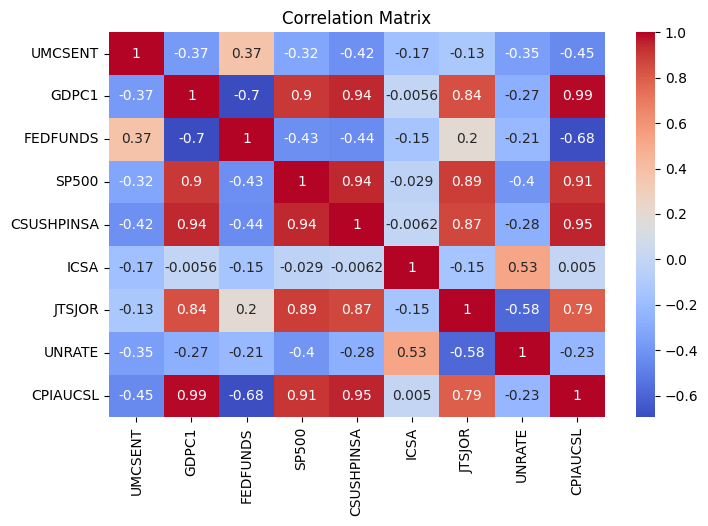

In [68]:
corr_matrix = df[['UMCSENT', 'GDPC1', 'FEDFUNDS', 'SP500', 'CSUSHPINSA', 'ICSA', 'JTSJOR', 'UNRATE', 'CPIAUCSL']].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [69]:
# Ensure DATE is in datetime format for time-series analysis
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.drop(['PCE'], axis = 1)

# Define columns to lag (excluding DATE and UNRATE)
columns_to_lag = [col for col in df.columns if col not in ['DATE', 'UNRATE']]

# Create lagged variables for t-1 through t-6
lagged_df = df.copy()
for lag in range(1, 7):  # Create lagged variables up to t-6
    for col in columns_to_lag:
        lagged_df[f'{col} (t-{lag})'] = df[col].shift(lag)

lagged_df.tail(4) # Do not remove NaN

,DATE,UMCSENT,GDPC1,FEDFUNDS,SP500,CSUSHPINSA,ICSA,JTSJOR,UNRATE,CPIAUCSL,UMCSENT (t-1),GDPC1 (t-1),FEDFUNDS (t-1),SP500 (t-1),CSUSHPINSA (t-1),ICSA (t-1),JTSJOR (t-1),CPIAUCSL (t-1),UMCSENT (t-2),GDPC1 (t-2),FEDFUNDS (t-2),SP500 (t-2),CSUSHPINSA (t-2),ICSA (t-2),JTSJOR (t-2),CPIAUCSL (t-2),UMCSENT (t-3),GDPC1 (t-3),FEDFUNDS (t-3),SP500 (t-3),CSUSHPINSA (t-3),ICSA (t-3),JTSJOR (t-3),CPIAUCSL (t-3),UMCSENT (t-4),GDPC1 (t-4),FEDFUNDS (t-4),SP500 (t-4),CSUSHPINSA (t-4),ICSA (t-4),JTSJOR (t-4),CPIAUCSL (t-4),UMCSENT (t-5),GDPC1 (t-5),FEDFUNDS (t-5),SP500 (t-5),CSUSHPINSA (t-5),ICSA (t-5),JTSJOR (t-5),CPIAUCSL (t-5),UMCSENT (t-6),GDPC1 (t-6),FEDFUNDS (t-6),SP500 (t-6),CSUSHPINSA (t-6),ICSA (t-6),JTSJOR (t-6),CPIAUCSL (t-6)
487,2024-08-01,67.9,7795.416,5.33,5478.215,325.025,1155000.0,4.7,4.2,314.121,66.4,7795.416,5.33,5538.005,325.461,953000.0,4.6,313.534,68.2,7741.302,5.33,5415.141,325.436,1184000.0,4.8,313.049,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225,77.2,7741.302,5.33,5112.493,320.885,841000.0,4.8,313.207,79.4,7684.515,5.33,5170.573,316.972,1068000.0,5.0,312.230,76.9,7684.515,5.33,5011.962,312.799,837000.0,5.3,311.054
488,2024-09-01,70.1,7795.416,5.13,5621.261,324.796,897000.0,4.5,4.1,314.686,67.9,7795.416,5.33,5478.215,325.025,1155000.0,4.7,314.121,66.4,7795.416,5.33,5538.005,325.461,953000.0,4.6,313.534,68.2,7741.302,5.33,5415.141,325.436,1184000.0,4.8,313.049,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225,77.2,7741.302,5.33,5112.493,320.885,841000.0,4.8,313.207,79.4,7684.515,5.33,5170.573,316.972,1068000.0,5.0,312.230
489,2024-10-01,70.5,NaN,4.83,5792.320,NaN,948000.0,4.6,4.1,315.454,70.1,7795.416,5.13,5621.261,324.796,897000.0,4.5,314.686,67.9,7795.416,5.33,5478.215,325.025,1155000.0,4.7,314.121,66.4,7795.416,5.33,5538.005,325.461,953000.0,4.6,313.534,68.2,7741.302,5.33,5415.141,325.436,1184000.0,4.8,313.049,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225,77.2,7741.302,5.33,5112.493,320.885,841000.0,4.8,313.207
490,2024-11-01,NaN,NaN,4.64,NaN,NaN,NaN,NaN,NaN,NaN,70.5,NaN,4.83,5792.320,NaN,948000.0,4.6,315.454,70.1,7795.416,5.13,5621.261,324.796,897000.0,4.5,314.686,67.9,7795.416,5.33,5478.215,325.025,1155000.0,4.7,314.121,66.4,7795.416,5.33,5538.005,325.461,953000.0,4.6,313.534,68.2,7741.302,5.33,5415.141,325.436,1184000.0,4.8,313.049,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225


In [70]:
# Save November data for later
november_df = lagged_df.iloc[-1:]
lagged_df = lagged_df.iloc[:-1]

# Reset the index to ensure .loc[0] works as expected
november_df = november_df.reset_index(drop=True)

# Add new values (updated after retrieval of data)
november_df.loc[0, 'GDPC1 (t-1)'] = 7795.416
november_df.loc[0, 'CSUSHPINSA (t-1)'] = 324.796

# Add Intercept column
november_df.insert(0, 'Intercept', 1.0)
november_df

,Intercept,DATE,UMCSENT,GDPC1,FEDFUNDS,SP500,CSUSHPINSA,ICSA,JTSJOR,UNRATE,CPIAUCSL,UMCSENT (t-1),GDPC1 (t-1),FEDFUNDS (t-1),SP500 (t-1),CSUSHPINSA (t-1),ICSA (t-1),JTSJOR (t-1),CPIAUCSL (t-1),UMCSENT (t-2),GDPC1 (t-2),FEDFUNDS (t-2),SP500 (t-2),CSUSHPINSA (t-2),ICSA (t-2),JTSJOR (t-2),CPIAUCSL (t-2),UMCSENT (t-3),GDPC1 (t-3),FEDFUNDS (t-3),SP500 (t-3),CSUSHPINSA (t-3),ICSA (t-3),JTSJOR (t-3),CPIAUCSL (t-3),UMCSENT (t-4),GDPC1 (t-4),FEDFUNDS (t-4),SP500 (t-4),CSUSHPINSA (t-4),ICSA (t-4),JTSJOR (t-4),CPIAUCSL (t-4),UMCSENT (t-5),GDPC1 (t-5),FEDFUNDS (t-5),SP500 (t-5),CSUSHPINSA (t-5),ICSA (t-5),JTSJOR (t-5),CPIAUCSL (t-5),UMCSENT (t-6),GDPC1 (t-6),FEDFUNDS (t-6),SP500 (t-6),CSUSHPINSA (t-6),ICSA (t-6),JTSJOR (t-6),CPIAUCSL (t-6)
0,1.0,2024-11-01,NaN,NaN,4.64,NaN,NaN,NaN,NaN,NaN,NaN,70.5,7795.416,4.83,5792.32,324.796,948000.0,4.6,315.454,70.1,7795.416,5.13,5621.261,324.796,897000.0,4.5,314.686,67.9,7795.416,5.33,5478.215,325.025,1155000.0,4.7,314.121,66.4,7795.416,5.33,5538.005,325.461,953000.0,4.6,313.534,68.2,7741.302,5.33,5415.141,325.436,1184000.0,4.8,313.049,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225


In [71]:
lagged_df.tail()

,DATE,UMCSENT,GDPC1,FEDFUNDS,SP500,CSUSHPINSA,ICSA,JTSJOR,UNRATE,CPIAUCSL,UMCSENT (t-1),GDPC1 (t-1),FEDFUNDS (t-1),SP500 (t-1),CSUSHPINSA (t-1),ICSA (t-1),JTSJOR (t-1),CPIAUCSL (t-1),UMCSENT (t-2),GDPC1 (t-2),FEDFUNDS (t-2),SP500 (t-2),CSUSHPINSA (t-2),ICSA (t-2),JTSJOR (t-2),CPIAUCSL (t-2),UMCSENT (t-3),GDPC1 (t-3),FEDFUNDS (t-3),SP500 (t-3),CSUSHPINSA (t-3),ICSA (t-3),JTSJOR (t-3),CPIAUCSL (t-3),UMCSENT (t-4),GDPC1 (t-4),FEDFUNDS (t-4),SP500 (t-4),CSUSHPINSA (t-4),ICSA (t-4),JTSJOR (t-4),CPIAUCSL (t-4),UMCSENT (t-5),GDPC1 (t-5),FEDFUNDS (t-5),SP500 (t-5),CSUSHPINSA (t-5),ICSA (t-5),JTSJOR (t-5),CPIAUCSL (t-5),UMCSENT (t-6),GDPC1 (t-6),FEDFUNDS (t-6),SP500 (t-6),CSUSHPINSA (t-6),ICSA (t-6),JTSJOR (t-6),CPIAUCSL (t-6)
485,2024-06-01,68.2,7741.302,5.33,5415.141,325.436,1184000.0,4.8,4.1,313.049,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225,77.2,7741.302,5.33,5112.493,320.885,841000.0,4.8,313.207,79.4,7684.515,5.33,5170.573,316.972,1068000.0,5.0,312.230,76.9,7684.515,5.33,5011.962,312.799,837000.0,5.3,311.054,79.0,7684.515,5.33,4804.491,310.883,838000.0,5.3,309.685,69.7,7653.533,5.33,4685.052,311.053,1039000.0,5.3,308.742
486,2024-07-01,66.4,7795.416,5.33,5538.005,325.461,953000.0,4.6,4.3,313.534,68.2,7741.302,5.33,5415.141,325.436,1184000.0,4.8,313.049,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225,77.2,7741.302,5.33,5112.493,320.885,841000.0,4.8,313.207,79.4,7684.515,5.33,5170.573,316.972,1068000.0,5.0,312.230,76.9,7684.515,5.33,5011.962,312.799,837000.0,5.3,311.054,79.0,7684.515,5.33,4804.491,310.883,838000.0,5.3,309.685
487,2024-08-01,67.9,7795.416,5.33,5478.215,325.025,1155000.0,4.7,4.2,314.121,66.4,7795.416,5.33,5538.005,325.461,953000.0,4.6,313.534,68.2,7741.302,5.33,5415.141,325.436,1184000.0,4.8,313.049,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225,77.2,7741.302,5.33,5112.493,320.885,841000.0,4.8,313.207,79.4,7684.515,5.33,5170.573,316.972,1068000.0,5.0,312.230,76.9,7684.515,5.33,5011.962,312.799,837000.0,5.3,311.054
488,2024-09-01,70.1,7795.416,5.13,5621.261,324.796,897000.0,4.5,4.1,314.686,67.9,7795.416,5.33,5478.215,325.025,1155000.0,4.7,314.121,66.4,7795.416,5.33,5538.005,325.461,953000.0,4.6,313.534,68.2,7741.302,5.33,5415.141,325.436,1184000.0,4.8,313.049,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225,77.2,7741.302,5.33,5112.493,320.885,841000.0,4.8,313.207,79.4,7684.515,5.33,5170.573,316.972,1068000.0,5.0,312.230
489,2024-10-01,70.5,NaN,4.83,5792.320,NaN,948000.0,4.6,4.1,315.454,70.1,7795.416,5.13,5621.261,324.796,897000.0,4.5,314.686,67.9,7795.416,5.33,5478.215,325.025,1155000.0,4.7,314.121,66.4,7795.416,5.33,5538.005,325.461,953000.0,4.6,313.534,68.2,7741.302,5.33,5415.141,325.436,1184000.0,4.8,313.049,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225,77.2,7741.302,5.33,5112.493,320.885,841000.0,4.8,313.207


In [72]:
# define target variable "UNRATE"
y = lagged_df["UNRATE"]
y_summary = y.describe()

# Sort the values in ascending order
y_sorted = np.sort(y)

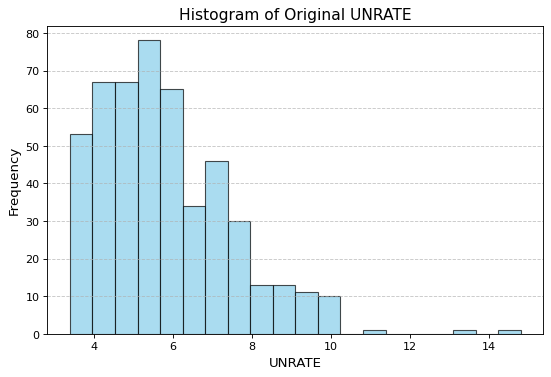

In [73]:
# Histogram of the original UNRATE
plt.figure(figsize=(8, 5), dpi=80)
plt.hist(lagged_df["UNRATE"], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Original UNRATE', fontsize=14)
plt.xlabel('UNRATE', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

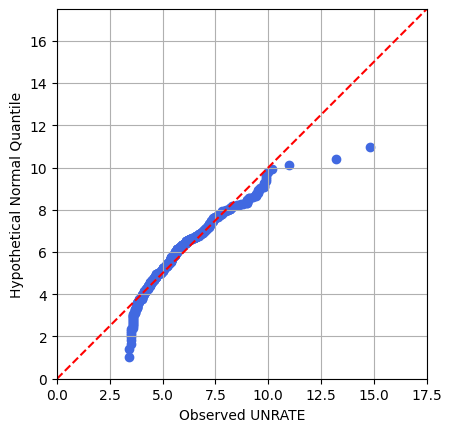

In [74]:
# Calculate the hypothetical quantiles
n_sample = y_summary['count']
y_mean = y_summary['mean']
y_stddev = y_summary['std']

empirical_prob = np.arange(1.0, (n_sample+1.0)) / (n_sample + 0.5)
z_quantile = norm.ppf(empirical_prob, loc = y_mean, scale = y_stddev)

fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 100)
ax.scatter(y_sorted, z_quantile, marker = 'o', c = 'royalblue')
ax.set_aspect(1.0)
ax.set_xlim([0,17.5])
ax.set_ylim([0,17.5])
ax.axline((y_mean,y_mean), slope = 1.0, linestyle = '--', color = 'red')
ax.set_xlabel('Observed UNRATE')
ax.set_ylabel('Hypothetical Normal Quantile')
ax.margins(x = 0.1, y = 0.1)
ax.grid()
plt.show()

In [75]:
# Correlatiob between Observed PCE and Hypothetical Normal Quantile
pearson_corr = np.corrcoef(y_sorted, z_quantile)[0,1]
print('Pearson Correlation = ', pearson_corr)

Pearson Correlation =  0.9654679619818356


In [76]:
# Average absolute distance of points from the ideal reference line
dist_ideal = np.mean(np.abs(y_sorted - z_quantile))
print('Mean Absolute Distance = ', dist_ideal)

Mean Absolute Distance =  0.2811332032244005


In [77]:
# Shapiro-Wilks test for normality
shapiro_test = shapiro(y)
print('\nShapiro Test = ', shapiro_test[0])
print('     p-value = ', shapiro_test[1])


Shapiro Test =  0.9298395872668281
     p-value =  2.1987206262459095e-14


In [78]:
# Anderson-Darling test for normality
anderson_test = anderson(y, dist = 'norm')
print('\n  Anderson Test = ', anderson_test[0])
print('Critical Values = ', anderson_test[1])
print('       p-values = ', anderson_test[2]/100.0)


  Anderson Test =  7.158210075260854
Critical Values =  [0.571 0.651 0.781 0.911 1.083]
       p-values =  [0.15  0.1   0.05  0.025 0.01 ]


In [79]:
def BoxCoxTransform (y, p):
   if (p == 0):
      y1 = np.log(y)
   else:
      y1 = (np.power(y,p) - 1.0) / p
   return (y1)

def InverseBoxCoxTransform(y1, p):
    if p == 0:
        y = np.exp(y1)
    else:
        y = np.power((y1 * p) + 1, 1 / p)
    return y

In [80]:
result_list = []
for power_lambda in np.arange(-2.0, 2.1, 0.5):
   y1 = y.apply(BoxCoxTransform, p = power_lambda)
   y1_sorted = np.sort(y1)
   y1_mean = np.mean(y1)
   y1_stddev = np.std(y1, ddof = 1)
   z_quantile = norm.ppf(empirical_prob, loc = y1_mean, scale = y1_stddev)

   pearson_corr = np.corrcoef(y1_sorted, z_quantile)[0,1]
   dist_ideal = np.mean(np.abs(y1_sorted - z_quantile)) / y1_stddev
   shapiro_test = shapiro(y1)
   anderson_test = anderson(y1, dist = 'norm')

   result_list.append([power_lambda, pearson_corr, dist_ideal, shapiro_test[0], anderson_test[0]])

result_df = pd.DataFrame(result_list, columns = ['Power', 'Corr', 'MAD', 'Shapiro', 'Anderson'])

In [81]:
# Apply Box-Cox Transformation
power_lambda =  result_df.iloc[result_df['MAD'].idxmin()]['Power']
print(f'Power Lambda: {power_lambda}')
lagged_df["UNRATE"] = lagged_df["UNRATE"].apply(BoxCoxTransform, p = power_lambda)

Power Lambda: -0.5


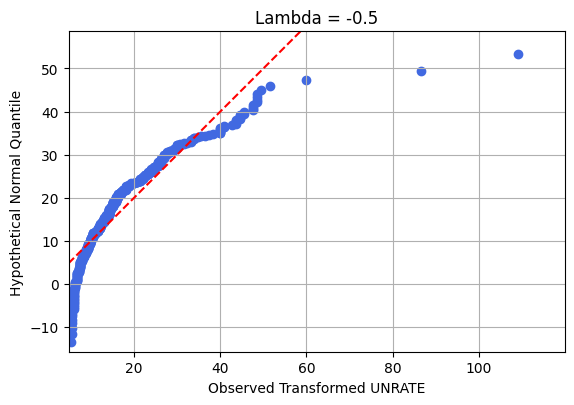

In [82]:
# Recompute empirical probabilities and quantiles
empirical_prob = (np.arange(1, len(y1_sorted) + 1) - 0.5) / len(y1_sorted)
z_quantile = norm.ppf(empirical_prob, loc=y1_mean, scale=y1_stddev)

# Recompute statistics
pearson_corr = np.corrcoef(y1_sorted, z_quantile)[0, 1]
dist_ideal = np.mean(np.abs(y1_sorted - z_quantile))
shapiro_test = shapiro(y1)
anderson_test = anderson(y1, dist='norm')

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=100)
ax.scatter(y1_sorted, z_quantile, marker='o', c='royalblue')
ax.set_aspect(1.0)
ax.axline((y1_mean, y1_mean), slope=1.0, linestyle='--', color='red')
ax.set_xlim([min(y1_sorted) * 0.9, max(y1_sorted) * 1.1])
ax.set_ylim([min(z_quantile) * 0.9, max(z_quantile) * 1.1])
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Observed Transformed UNRATE')
ax.set_ylabel('Hypothetical Normal Quantile')
ax.set_title('Lambda = ' + str(power_lambda))
ax.margins(x=0.1, y=0.1)
ax.grid()
plt.show()

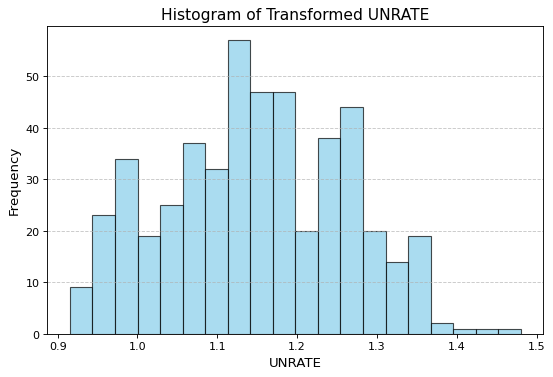

In [83]:
# Histogram of the original UNRATE
plt.figure(figsize=(8, 5), dpi=80)
plt.hist(lagged_df["UNRATE"], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Transformed UNRATE', fontsize=14)
plt.xlabel('UNRATE', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [84]:
# =================
# Model training
# =================

train_data = lagged_df.loc[lagged_df['DATE'] <= '2024-10-01'].dropna().reset_index(drop = True)
train_data = train_data.drop(columns=["DATE", "UMCSENT", "GDPC1", "FEDFUNDS", "SP500", "CSUSHPINSA", "ICSA", "JTSJOR", "CPIAUCSL"])
target_name = 'UNRATE'
candidate_name = [col for col in train_data.columns if col != target_name]
candidate_count = len(candidate_name)
train_data.tail()

,UNRATE,UMCSENT (t-1),GDPC1 (t-1),FEDFUNDS (t-1),SP500 (t-1),CSUSHPINSA (t-1),ICSA (t-1),JTSJOR (t-1),CPIAUCSL (t-1),UMCSENT (t-2),GDPC1 (t-2),FEDFUNDS (t-2),SP500 (t-2),CSUSHPINSA (t-2),ICSA (t-2),JTSJOR (t-2),CPIAUCSL (t-2),UMCSENT (t-3),GDPC1 (t-3),FEDFUNDS (t-3),SP500 (t-3),CSUSHPINSA (t-3),ICSA (t-3),JTSJOR (t-3),CPIAUCSL (t-3),UMCSENT (t-4),GDPC1 (t-4),FEDFUNDS (t-4),SP500 (t-4),CSUSHPINSA (t-4),ICSA (t-4),JTSJOR (t-4),CPIAUCSL (t-4),UMCSENT (t-5),GDPC1 (t-5),FEDFUNDS (t-5),SP500 (t-5),CSUSHPINSA (t-5),ICSA (t-5),JTSJOR (t-5),CPIAUCSL (t-5),UMCSENT (t-6),GDPC1 (t-6),FEDFUNDS (t-6),SP500 (t-6),CSUSHPINSA (t-6),ICSA (t-6),JTSJOR (t-6),CPIAUCSL (t-6)
275,1.000000,77.2,7741.302,5.33,5112.493,320.885,841000.0,4.8,313.207,79.4,7684.515,5.33,5170.573,316.972,1068000.0,5.0,312.230,76.9,7684.515,5.33,5011.962,312.799,837000.0,5.3,311.054,79.0,7684.515,5.33,4804.491,310.883,838000.0,5.3,309.685,69.7,7653.533,5.33,4685.052,311.053,1039000.0,5.3,308.742,61.3,7653.533,5.33,4460.063,312.235,870000.0,5.4,308.024
276,1.012270,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225,77.2,7741.302,5.33,5112.493,320.885,841000.0,4.8,313.207,79.4,7684.515,5.33,5170.573,316.972,1068000.0,5.0,312.230,76.9,7684.515,5.33,5011.962,312.799,837000.0,5.3,311.054,79.0,7684.515,5.33,4804.491,310.883,838000.0,5.3,309.685,69.7,7653.533,5.33,4685.052,311.053,1039000.0,5.3,308.742
277,1.035514,68.2,7741.302,5.33,5415.141,325.436,1184000.0,4.8,313.049,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225,77.2,7741.302,5.33,5112.493,320.885,841000.0,4.8,313.207,79.4,7684.515,5.33,5170.573,316.972,1068000.0,5.0,312.230,76.9,7684.515,5.33,5011.962,312.799,837000.0,5.3,311.054,79.0,7684.515,5.33,4804.491,310.883,838000.0,5.3,309.685
278,1.024100,66.4,7795.416,5.33,5538.005,325.461,953000.0,4.6,313.534,68.2,7741.302,5.33,5415.141,325.436,1184000.0,4.8,313.049,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225,77.2,7741.302,5.33,5112.493,320.885,841000.0,4.8,313.207,79.4,7684.515,5.33,5170.573,316.972,1068000.0,5.0,312.230,76.9,7684.515,5.33,5011.962,312.799,837000.0,5.3,311.054
279,1.012270,67.9,7795.416,5.33,5478.215,325.025,1155000.0,4.7,314.121,66.4,7795.416,5.33,5538.005,325.461,953000.0,4.6,313.534,68.2,7741.302,5.33,5415.141,325.436,1184000.0,4.8,313.049,69.1,7741.302,5.33,5235.225,323.859,892000.0,4.9,313.225,77.2,7741.302,5.33,5112.493,320.885,841000.0,4.8,313.207,79.4,7684.515,5.33,5170.573,316.972,1068000.0,5.0,312.230


In [85]:
# =================
# Feature engineering
# =================

# Backward Selection
remove_threshold = 0.01
q_show_diary = False
step_diary = []
n_sample = train_data.shape[0]

def takeFSig(s):
    return s[6]

var_in_model = ['Intercept'] + candidate_name

# Step 0: Enter Intercept and all candidates
# X1 = pd.get_dummies(train_data[categorical_feature].astype('category'), dtype = float)
y = train_data[target_name]
X1 = train_data[candidate_name]
X1.insert(0, 'Intercept', 1.0)
X1_columns = X1.columns

result_list = LinearRegression(X1, y)
m1 = len(result_list[5])

# residual_variance = result_list[2] and residual_df = result_list[3]
SSE1 = result_list[2] * result_list[3]

step_diary.append([0, 'None', SSE1, m1] + 4 * [np.nan])

# Backward Selection Steps
for iStep in range(candidate_count):
    FTest = []
    for pred in candidate_name:
        drop_cols = [col for col in X1_columns if pred in col]
        X = X1.drop(columns = drop_cols)

        result_list = LinearRegression(X, y)
        m0 = len(result_list[5])
        SSE0 = result_list[2] * result_list[3]

        df_numer = m1 - m0
        df_denom = n_sample - m1
        if (df_numer > 0 and df_denom > 0):
            FStat = ((SSE0 - SSE1) / df_numer) / (SSE1 / df_denom)
            FSig = f.sf(FStat, df_numer, df_denom)
            FTest.append([pred, SSE0, m0, FStat, df_numer, df_denom, FSig])


    # Show F Test results for the current step
    if (q_show_diary):
        print('\n===== F Test Results for the Current Backward Step =====')
        print('Step Number: ', iStep)
        print('Step Diary:')
        print('[Variable Candidate | Residual Sum of Squares | N Non-Aliased Parameters | F Stat | F DF1 | F DF2 | F Sig]')
        for row in FTest:
            print(row)

    print("Variables currently in model:", var_in_model)

    FTest.sort(key = takeFSig, reverse = True)
    FSig = takeFSig(FTest[0])
    if (FSig >= remove_threshold):
        remove_var = FTest[0][0]
        SSE1 = FTest[0][1]
        m1 = FTest[0][2]

        print("Variable removed in this step:", remove_var)

        step_diary.append([iStep+1] + FTest[0])
        drop_cols = [col for col in X1_columns if remove_var in col]
        X1 = X1.drop(columns = drop_cols)
        X1_columns = X1.columns
        var_in_model.remove(remove_var)
        candidate_name.remove(remove_var)
    else:
        break

backward_summary = pd.DataFrame(step_diary, columns = ['Step', 'Variable Removed', 'Residual Sum of Squares', 'N Non-Aliased Parameters', 'F Stat', 'F DF1', 'F DF2', 'F Sig'])


Variables currently in model: ['Intercept', 'UMCSENT (t-1)', 'GDPC1 (t-1)', 'FEDFUNDS (t-1)', 'SP500 (t-1)', 'CSUSHPINSA (t-1)', 'ICSA (t-1)', 'JTSJOR (t-1)', 'CPIAUCSL (t-1)', 'UMCSENT (t-2)', 'GDPC1 (t-2)', 'FEDFUNDS (t-2)', 'SP500 (t-2)', 'CSUSHPINSA (t-2)', 'ICSA (t-2)', 'JTSJOR (t-2)', 'CPIAUCSL (t-2)', 'UMCSENT (t-3)', 'GDPC1 (t-3)', 'FEDFUNDS (t-3)', 'SP500 (t-3)', 'CSUSHPINSA (t-3)', 'ICSA (t-3)', 'JTSJOR (t-3)', 'CPIAUCSL (t-3)', 'UMCSENT (t-4)', 'GDPC1 (t-4)', 'FEDFUNDS (t-4)', 'SP500 (t-4)', 'CSUSHPINSA (t-4)', 'ICSA (t-4)', 'JTSJOR (t-4)', 'CPIAUCSL (t-4)', 'UMCSENT (t-5)', 'GDPC1 (t-5)', 'FEDFUNDS (t-5)', 'SP500 (t-5)', 'CSUSHPINSA (t-5)', 'ICSA (t-5)', 'JTSJOR (t-5)', 'CPIAUCSL (t-5)', 'UMCSENT (t-6)', 'GDPC1 (t-6)', 'FEDFUNDS (t-6)', 'SP500 (t-6)', 'CSUSHPINSA (t-6)', 'ICSA (t-6)', 'JTSJOR (t-6)', 'CPIAUCSL (t-6)']
Variable removed in this step: CPIAUCSL (t-4)
Variables currently in model: ['Intercept', 'UMCSENT (t-1)', 'GDPC1 (t-1)', 'FEDFUNDS (t-1)', 'SP500 (t-1)', 'CS

In [86]:
backward_summary

,Step,Variable Removed,Residual Sum of Squares,N Non-Aliased Parameters,F Stat,F DF1,F DF2,F Sig
0,0,None,0.135476,49,NaN,NaN,NaN,NaN
1,1,CPIAUCSL (t-4),0.135478,48,0.004179,1.0,231.0,0.948511
2,2,GDPC1 (t-3),0.135481,47,0.004616,1.0,232.0,0.945893
3,3,CSUSHPINSA (t-4),0.135483,46,0.004289,1.0,233.0,0.947837
4,4,JTSJOR (t-5),0.135497,45,0.023473,1.0,234.0,0.878366
5,5,CSUSHPINSA (t-6),0.135515,44,0.032066,1.0,235.0,0.858037
6,6,SP500 (t-3),0.135533,43,0.030932,1.0,236.0,0.860543
7,7,FEDFUNDS (t-6),0.135564,42,0.053914,1.0,237.0,0.816587
8,8,JTSJOR (t-3),0.135606,41,0.073137,1.0,238.0,0.787058
9,9,UMCSENT (t-4),0.135690,40,0.148046,1.0,239.0,0.700752


In [87]:
result_list = LinearRegression(X1, y)
result_list[0]

,Estimate,Standard Error,t,Significance,Lower 95 CI,Upper 95 CI
Intercept,1.733134e+00,3.427955e-02,50.558822,1.759484e-137,1.665636e+00,1.800631e+00
UMCSENT (t-1),-2.379553e-03,2.522082e-04,-9.434874,2.170041e-18,-2.876157e-03,-1.882949e-03
GDPC1 (t-1),1.497402e-04,4.583196e-05,3.267157,1.230767e-03,5.949593e-05,2.399845e-04
ICSA (t-1),3.942769e-08,2.140643e-09,18.418618,3.154114e-49,3.521271e-08,4.364267e-08
GDPC1 (t-2),-2.436259e-04,4.313747e-05,-5.647663,4.213251e-08,-3.285646e-04,-1.586871e-04
SP500 (t-2),8.267685e-05,1.129082e-05,7.322485,2.972130e-12,6.044495e-05,1.049088e-04
ICSA (t-2),-1.127257e-08,2.588761e-09,-4.354428,1.912863e-05,-1.636991e-08,-6.175238e-09
JTSJOR (t-2),4.308680e-02,8.384664e-03,5.138763,5.397418e-07,2.657719e-02,5.959642e-02
FEDFUNDS (t-3),-1.422777e-02,1.556349e-03,-9.141764,1.724907e-17,-1.729226e-02,-1.116328e-02
ICSA (t-3),1.787125e-08,2.630731e-09,6.793262,7.292634e-11,1.269127e-08,2.305122e-08


In [88]:
result_list[0].sort_values(by = 'Significance')

,Estimate,Standard Error,t,Significance,Lower 95 CI,Upper 95 CI
Intercept,1.733134e+00,3.427955e-02,50.558822,1.759484e-137,1.665636e+00,1.800631e+00
ICSA (t-1),3.942769e-08,2.140643e-09,18.418618,3.154114e-49,3.521271e-08,4.364267e-08
UMCSENT (t-1),-2.379553e-03,2.522082e-04,-9.434874,2.170041e-18,-2.876157e-03,-1.882949e-03
FEDFUNDS (t-3),-1.422777e-02,1.556349e-03,-9.141764,1.724907e-17,-1.729226e-02,-1.116328e-02
JTSJOR (t-6),-6.121028e-02,7.869498e-03,-7.778168,1.676814e-13,-7.670551e-02,-4.571504e-02
SP500 (t-2),8.267685e-05,1.129082e-05,7.322485,2.972130e-12,6.044495e-05,1.049088e-04
ICSA (t-3),1.787125e-08,2.630731e-09,6.793262,7.292634e-11,1.269127e-08,2.305122e-08
GDPC1 (t-2),-2.436259e-04,4.313747e-05,-5.647663,4.213251e-08,-3.285646e-04,-1.586871e-04
CPIAUCSL (t-6),2.457320e-03,4.399125e-04,5.585929,5.795325e-08,1.591122e-03,3.323519e-03
CSUSHPINSA (t-5),-8.293878e-04,1.503893e-04,-5.514939,8.335244e-08,-1.125508e-03,-5.332675e-04


In [89]:
def PearsonCorrelation (x, y):
   '''Compute the Pearson correlation between two arrays x and y with the
   same number of values

   Argument:
   ---------
   x : a Pandas Series
   y : a Pandas Series

   Output:
   -------
   rho : Pearson correlation
   '''

   dev_x = x - np.mean(x)
   dev_y = y - np.mean(y)

   ss_xx = np.mean(dev_x * dev_x)
   ss_yy = np.mean(dev_y * dev_y)

   if (ss_xx > 0.0 and ss_yy > 0.0):
      ss_xy = np.mean(dev_x * dev_y)
      rho = (ss_xy / ss_xx) * (ss_xy / ss_yy)
      rho = np.sign(ss_xy) * np.sqrt(rho)
   else:
      rho = np.nan

   return (rho)

In [90]:
# =================
# Model Performance
# =================

# Root Mean Squared Error
y_prediction = X1.dot(result_list[0]['Estimate'])
rmse = np.sqrt(np.mean((y_prediction - train_data['UNRATE']) ** 2))

# Relative Error
observed = train_data['UNRATE']
relative_error = np.mean(np.abs((observed - y_prediction) / observed)) * 100

# r squared
corr_y_prediction = PearsonCorrelation (y, y_prediction)
R_Square = np.square(corr_y_prediction)


print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Relative Error: {relative_error:.4f}")
print(f"R Squared: {R_Square:.4f}")

Root Mean Squared Error (RMSE): 0.0241
Relative Error: 1.6990
R Squared: 0.9654


In [91]:
# =================
# Making predictions
# =================

y_real = y_prediction.apply(InverseBoxCoxTransform, p = power_lambda)
y_real

0      4.429171
1      4.598947
2      4.580069
3      5.173799
4      5.455847
         ...   
275    4.004455
276    3.854652
277    4.074928
278    4.109152
279    4.164566
Length: 280, dtype: float64

In [92]:
# Select just the columns of interest
november_df = november_df[X1.columns]
november_df

,Intercept,UMCSENT (t-1),GDPC1 (t-1),ICSA (t-1),GDPC1 (t-2),SP500 (t-2),ICSA (t-2),JTSJOR (t-2),FEDFUNDS (t-3),ICSA (t-3),ICSA (t-4),JTSJOR (t-4),UMCSENT (t-5),CSUSHPINSA (t-5),SP500 (t-6),JTSJOR (t-6),CPIAUCSL (t-6)
0,1.0,70.5,7795.416,948000.0,7795.416,5621.261,897000.0,4.5,5.33,1155000.0,953000.0,4.6,68.2,325.436,5235.225,4.9,313.225


In [93]:
# =================
# Making predictions
# =================

final_prediction = november_df.dot(result_list[0]['Estimate']).apply(InverseBoxCoxTransform, p = power_lambda)
print(f'Predicted UNRATE for November: {final_prediction[0]:.2f}')

Predicted UNRATE for November: 4.27


In [94]:
# Get the current time in CST
cst_timezone = pytz.timezone('US/Central')
current_time_cst = datetime.now(cst_timezone)

# Nicely format the time
formatted_time = current_time_cst.strftime('%Y-%m-%d %I:%M:%S %p %Z')
print("Last Executed Time in CST:", formatted_time)

Last Executed Time in CST: 2025-02-07 01:46:20 PM CST
